3a. test error: 1.625%
3b. top 5 predictive tokens: ['httpaddr' 'spam' 'unsubscrib' 'ebai' 'valet']


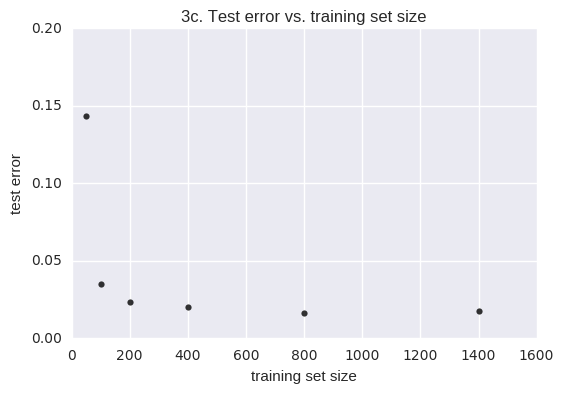

In [46]:
%matplotlib inline
import numpy as np
import io
import seaborn as sns

def readMatrix(file):
    f = open(file, "r")
    f.readline()
    dim = np.array(f.readline().split()).astype(np.int)
    tokenlist = np.array(f.readline().split())
    matrix = np.zeros((dim[0], dim[1]))
    category = np.zeros(dim[0])
    
    for i in np.arange(dim[0]):
        data = np.array(f.readline().split()).astype(np.int)
        category[i] = data[0]
        
        matrixindex = 0
        dataindex = 1
        while data[dataindex] != -1:
            matrixindex += data[dataindex]
            matrix[i, matrixindex] = data[dataindex+1]
            dataindex += 2

    f.close()
    return(matrix, tokenlist, category)

def nb_train(matrix, category):
    spam_prior = np.sum(category)/len(category) #fraction of training set that is spam
    
    spam_indices = category == 1 #boolean where Trues are spam rows
    spam_data = matrix[spam_indices,:] #split matrix into spam and nonspam matrices
    email_data = matrix[~spam_indices,:] 
    
    spam_token_probs = np.divide(np.sum(spam_data, axis=0) + 1, np.sum(spam_data) + spam_data.shape[0])
    email_token_probs = np.divide(np.sum(email_data, axis=0) + 1, np.sum(email_data) + email_data.shape[0])
        
    return(spam_prior, spam_token_probs, email_token_probs)

def nb_predict(matrix, spam_prior, spam_token_probs, email_token_probs):
    
    spam_odds = np.add(np.dot(matrix, np.log(spam_token_probs)), np.log(spam_prior))
    email_odds = np.add(np.dot(matrix, np.log(email_token_probs)), np.log(1-spam_prior))
      
    predictions = np.zeros(matrix.shape[0])
    predictions[spam_odds>email_odds] = 1
    
    return(predictions)

def get_error(predictions, labels):
    return(np.divide(np.sum(np.abs(np.subtract(predictions, labels))), len(labels)))

def main():
    #3a
    #import training data and fit parameters
    matrix, tokenlist, category = readMatrix('spam_data/MATRIX.TRAIN')
    spam_prior, spam_token_probs, email_token_probs = nb_train(matrix, category)
    
    #train_predictions = nb_predict(matrix, spam_prior, spam_token_probs, email_token_probs)
    
    #import test data, predict on test set, and report test error
    test_matrix, test_tokenlist, test_category = readMatrix('spam_data/MATRIX.TEST')
    test_predictions = nb_predict(test_matrix, spam_prior, spam_token_probs, email_token_probs)
    print("3a. test error: "+str(get_error(test_predictions, test_category)*100)+"%")
    
    #3b
    tokenratios = np.log(np.divide(spam_token_probs, email_token_probs))
    top_token_indices = np.argpartition(tokenratios, -5)[-5:]
    top_token_indices = top_token_indices[np.argsort(tokenratios[top_token_indices])]
    print("3b. top 5 predictive tokens: " + str(np.flip(tokenlist[top_token_indices], 0)))
    
    #3c
    trainsets = {'t50': readMatrix('spam_data/MATRIX.TRAIN.50'), 't100': readMatrix('spam_data/MATRIX.TRAIN.100'),
                 't200': readMatrix('spam_data/MATRIX.TRAIN.200'), 't400': readMatrix('spam_data/MATRIX.TRAIN.400'),
                 't800': readMatrix('spam_data/MATRIX.TRAIN.800'), 't1400': readMatrix('spam_data/MATRIX.TRAIN.1400')}
    
    errormatrix = np.zeros((len(trainsets), 2))
    i = 0
    for k in trainsets:
        errormatrix[i, 0] = trainsets[k][0].shape[0]
        model_priors, model_spam_probs, model_email_probs = nb_train(trainsets[k][0], trainsets[k][2])
        errormatrix[i, 1] = get_error(nb_predict(test_matrix, model_priors, model_spam_probs, model_email_probs), test_category)
        i += 1
        
    plot3c = sns.regplot(x=errormatrix[:,0], y=errormatrix[:,1], color='k', fit_reg=False)
    plot3c.set(ylim=(0, None), xlim=(0, None),
               xlabel="training set size", ylabel="test error", title="3c. Test error vs. training set size")
    plot3c.get_figure().savefig('figures/ps2-3c')
    
if __name__ == '__main__':
    main()